# Correction Term

Compute a correction term to improve accuracy of predicted frequency spektrum.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os

import sys
sys.path.append('../../')
from cad.calc.geo import Geo
from cad.calc.conv import freq_to_note_and_cent, note_name
import pandas as pd
import seaborn as sns
from sklearn import svm

import json

def do_fft(infile, maxfreq=1000):
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    size=len(signal)
    
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]
    #fft_spectrum_abs = np.log2(fft_spectrum_abs)

    return freq, fft_spectrum_abs

def get_harmonic_maxima(freq, spectrum, min_freq=60):
    i=0
    maxima = []
    base_freq = min_freq
    while i*base_freq<1000:
        if i==0:
            window = freq>min_freq
        else:
            window = (freq>(i+0.5)*base_freq) & (freq<base_freq*(i+1.5))

        if window.astype(int).sum() == 0:
            break
        window_f = freq[window]
        window_s = spectrum[window]
        maxi = np.argmax(window_s)
        max_f = window_f[maxi]
        if i==0:
            base_freq=max_f

        maxima.append(max_f)
        i+=1
    return maxima

# compute rms error of two ragged lists
# will be normalized by the length of each sublist and the number of ragged lists
def rms_error(measured_maxima, computed_maxima):
    error = 0
    for i in range(len(measured_maxima)):
        y = np.array(measured_maxima[i]) - np.array(computed_maxima[i])
        y = np.power(y, 2).sum()
        y = np.sqrt(y) / len(measured_maxima[i])
        error += y
    error /= len(measured_maxima)
    return error



In [2]:
# compute correction term over all data

# load didge archive
archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))

def train_and_evaluate(archive, train_indices, eval_indices):
    # collect training data
    computed_maxima = []
    measured_maxima = []
    for i in range(len(archive)):
        sound_file = os.path.join(archive_path, archive[i]["audio-samples"]["neutral-sound"])
        freq, spectrum = do_fft(sound_file)
        fft_maxima = get_harmonic_maxima(freq, spectrum)

        geo = json.load(open(os.path.join(archive_path, archive[i]["geometry"]), "r"))
        geo = Geo(geo)
        cadsd = geo.get_cadsd()
        ground_spektrum=cadsd.get_ground_spektrum()
        ground_freqs = np.array(list(ground_spektrum.keys()))
        ground_vols = np.array(list(ground_spektrum.values()))

        ground_maxima = get_harmonic_maxima(ground_freqs, ground_vols)
        l = min(len(fft_maxima), len(ground_maxima))
        measured_maxima.append(fft_maxima[0:l])
        computed_maxima.append(ground_maxima[0:l])

    computed_maxima = np.array(computed_maxima, dtype=object)
    measured_maxima = np.array(measured_maxima, dtype=object)
    
    # Train the regression model
    X = np.concatenate(computed_maxima[train_indices]).reshape((-1,1))
    y = np.concatenate(measured_maxima[train_indices])-np.concatenate(computed_maxima[train_indices])
    regr = svm.SVR()
    regr.fit(X, y)

    rms_before = rms_error(measured_maxima[eval_indices], computed_maxima[eval_indices])

    corrected_computed_maxima = []
    for m in computed_maxima[eval_indices]:
        X = np.array(m).reshape((-1,1))
        c = np.array(m) + regr.predict(X)
        corrected_computed_maxima.append(c)

    rms_cor = rms_error(measured_maxima[eval_indices], corrected_computed_maxima)
    
    return regr, rms_before, rms_cor

regr, rms_before, rms_cor = train_and_evaluate(archive, np.arange(len(archive)), np.arange(len(archive)))
print("rms without correction ", round(rms_before,2))
print("rms with correction ", round(rms_cor,2))

rms without correction  3.87
rms with correction  1.25


In [9]:
import pickle
pickle.dump(regr, open("correction_model.bin", "wb"))

In [3]:
# evaluate with an one against all approach
rms_uncorrected = []
rms_corrected = []
for i in range(len(archive)):
    train_indices = list(range(len(archive)))
    del train_indices[i]
    eval_indices = [i]
    
    regr, rms_before, rms_cor = train_and_evaluate(archive, train_indices, eval_indices)
    rms_uncorrected.append(rms_before)
    rms_corrected.append(rms_cor)
    
print(f"rms without correction {np.mean(rms_uncorrected):.2f} ({np.std(rms_uncorrected):.2f})")
print(f"rms with correction {np.mean(rms_corrected):.2f} ({np.std(rms_corrected):.2f})")

rms without correction 3.87 (0.76)
rms with correction 1.44 (0.84)


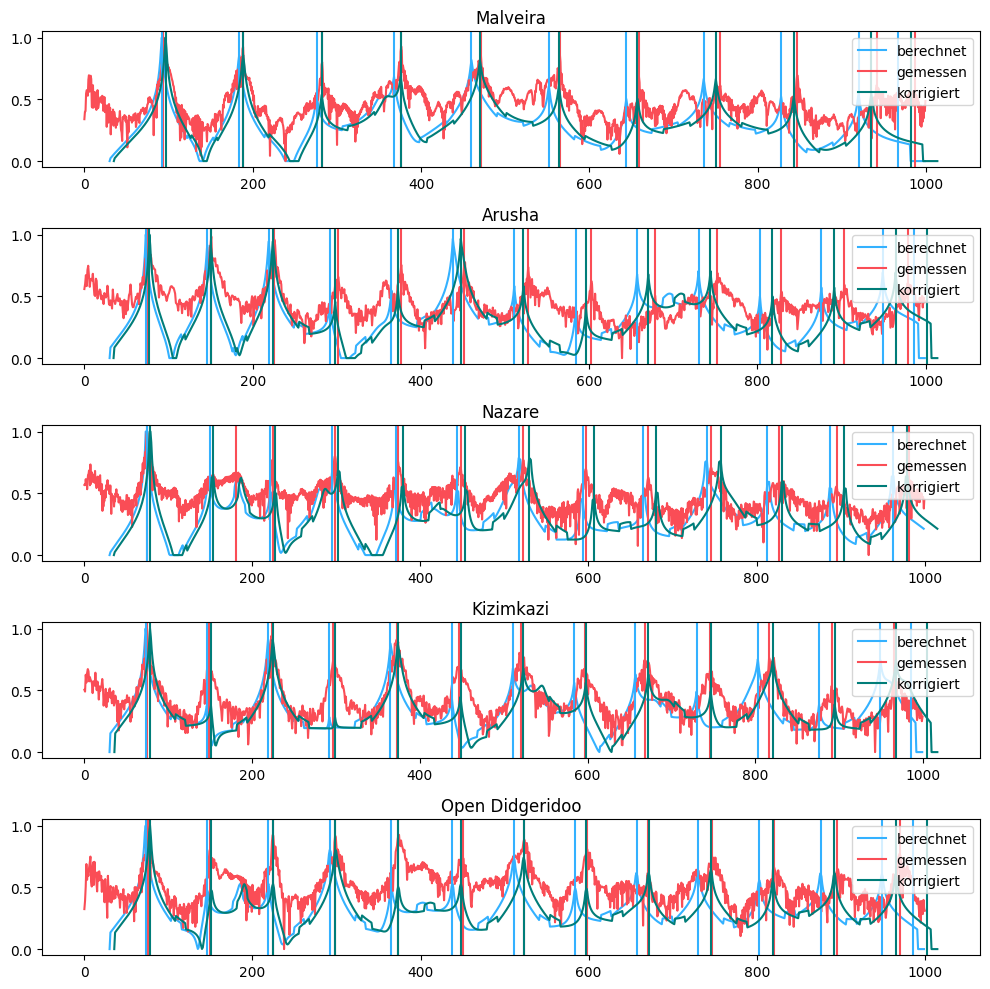

In [7]:
fig, axs = plt.subplots(len(archive), 1, figsize=(10,10))

didges = []

show_computed_ground_spectrum=True
show_computed_impedance_spectrum=False
show_original_fft=True
show_ground_peaks=True
show_fft_peaks=True
show_corrected_ground_spektrum=True
show_corrected_ground_peaks=True

colors = ['#8a3ffc', '#33b1ff', '#007d79', '#ff7eb6', '#fa4d56', '#fff1f1', '#6fdc8c', '#4589ff', '#d12771', '#d2a106', '#08bdba', '#bae6ff', '#ba4e00', '#d4bbff']

c1=1
c2=4
c3=2

for i in range(len(archive)):
    geo = json.load(open(os.path.join(archive_path, archive[i]["geometry"]), "r"))
    geo = Geo(geo)
    cadsd = geo.get_cadsd()
    
    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    
    if show_computed_ground_spectrum:
        axs[i].plot(ground_freqs, ground_vols, label="berechnet", color=colors[c1])

    sound_file = os.path.join(archive_path, archive[i]["audio-samples"]["neutral-sound"])
    freq, spectrum = do_fft(sound_file)
    spectrum = np.log2(spectrum)
    spectrum -= spectrum.min()
    spectrum /= spectrum.max()

    if show_original_fft:
        axs[i].plot(freq, spectrum, label=f"gemessen", color=colors[c2])
    
    if show_computed_impedance_spectrum:
        impedance_spektrum = cadsd.get_impedance_spektrum()
        impedance_freqs = impedance_spektrum.freq
        impedance_amps = impedance_spektrum.impedance
        impedance_amps -= impedance_amps.min()
        impedance_amps /= impedance_amps.max()
        axs[i].plot(impedance_freqs, impedance_amps, label=f"impedance")

    if show_fft_peaks:
        fft_maxima = get_harmonic_maxima(freq, spectrum)
        for m in fft_maxima:
            axs[i].axvline(x=m, color=colors[c2]) 
        
    if show_ground_peaks:
        ground_maxima = get_harmonic_maxima(ground_freqs, ground_vols)
        for m in ground_maxima:
            axs[i].axvline(x=m, color=colors[c1])

    # compute model with all shapes except this one
    train_indices = list(range(len(archive)))
    del train_indices[i]
    eval_indices = [i]
    regr, rms_before, rms_cor = train_and_evaluate(archive, train_indices, eval_indices)

    if show_corrected_ground_peaks:
        corrected_maxima_X = np.array(ground_maxima).reshape((-1,1))
        corrected_maxima = ground_maxima + regr.predict(corrected_maxima_X)
        for m in corrected_maxima:
            axs[i].axvline(x=m, color=colors[c3])
            
    if show_corrected_ground_spektrum:
        X = ground_freqs.reshape((-1,1))
        y = regr.predict(X)
        corrected_ground_freqs = ground_freqs + y
        axs[i].plot(corrected_ground_freqs, ground_vols, label=f"korrigiert", color=colors[c3])
        
    axs[i].legend()
    axs[i].set_title(archive[i]["name"])
    
    #break
fig.tight_layout()
plt.show()

In [72]:
np.arange(12).reshape((-1,3))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])